### 데이터 불러오기

In [ ]:
!pip install catboost
!pip install konlpy
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

### 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
### 데이터
%cd '/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트'
train = pd.read_csv('./review_train.csv', encoding='utf-8')
test = pd.read_csv('./review_test.csv', encoding='utf-8')
print(train.shape, test.shape)

/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트
(2026, 2) (400, 2)


In [ ]:
### label encoding
from sklearn.preprocessing import LabelEncoder
n = train.shape[0]
y = pd.concat([train,test])

le = LabelEncoder()
y['keyword2'] = le.fit_transform(y['keyword2'])
train = y[:n]
test = y[n:]

### NLP

In [ ]:
### okt
from konlpy.tag import Okt
okt = Okt()
train['okt'] = train['reviews'].apply(okt.morphs)
test['okt'] = test['reviews'].apply(okt.morphs)

In [ ]:
### 불용어 제거
with open('./new_stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.readlines()
stop_words = [word.strip() for word in stop_words]


def remove_stopwords(review):
    return [word for word in review if word not in stop_words]


train['okt'] = [remove_stopwords(review) for review in train['okt']]
test['okt'] = [remove_stopwords(review) for review in test['okt']]

In [7]:
### TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_okt = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=2,
                            max_df=0.95, stop_words=stop_words)
tfidf_okt_matrix = tfidf_okt.fit_transform(train['reviews'])
tfidf_okt_matrix_test = tfidf_okt.transform(test['reviews'])

In [8]:
### X/y split
X_train = tfidf_okt_matrix
y_train = train['keyword2']
X_test = tfidf_okt_matrix_test
y_test = test['keyword2']

### train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=2024
)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(1620, 92075) (406, 92075) (400, 92075)
(1620,) (406,) (400,)


### SVC

In [9]:
### loss function
import torch
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

[SVC] Validation Loss = 1.8106
[SVC] Validation Accuracy = 0.9384
[SVC] Validation F1 Score = 0.9362
[SVC] Test Loss = 2.3256
[SVC] Test Accuracy = 0.395
[SVC] Test F1 Score = 0.3823


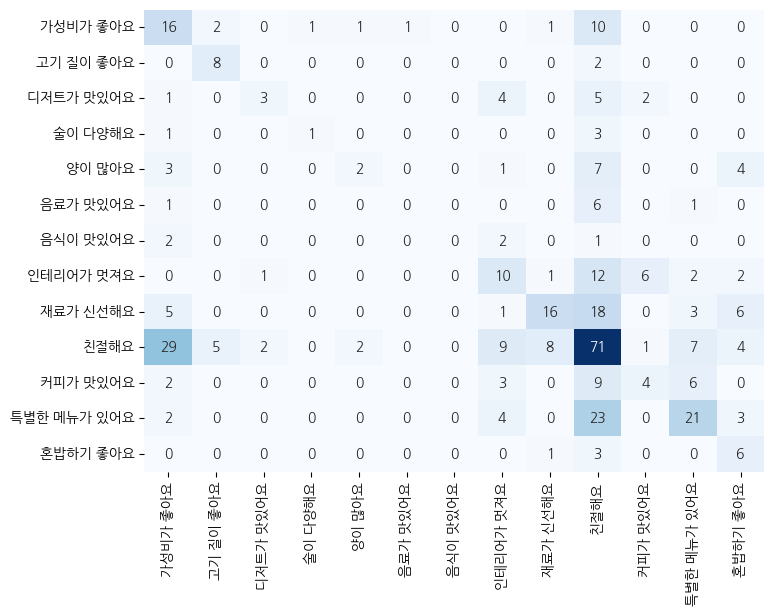

In [10]:
### SVM
svm = SVC(C=10, kernel='rbf', gamma=0.1, random_state=2024, probability=True)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_valid)
svm_proba = svm.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(svm_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, svm_pred)
valid_f1 = f1_score(y_valid, svm_pred, average='weighted')
print(f'[SVC] Validation Loss = {round(valid_loss,4)}')
print(f'[SVC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[SVC] Validation F1 Score = {round(valid_f1,4)}')

svm_test_pred = svm.predict(X_test)
svm_test_proba = svm.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(svm_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, svm_test_pred)
test_f1 = f1_score(y_test, svm_test_pred, average='weighted')
print(f'[SVC] Test Loss = {round(test_loss,4)}')
print(f'[SVC] Test Accuracy = {round(test_acc,4)}')
print(f'[SVC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

[SVC] Train Loss = 1.7006
[SVC] Train Accuracy = 0.9995
[SVC] Train F1 Score = 0.9995
[SVC] Test Loss = 2.3135
[SVC] Test Accuracy = 0.4075
[SVC] Test F1 Score = 0.3827


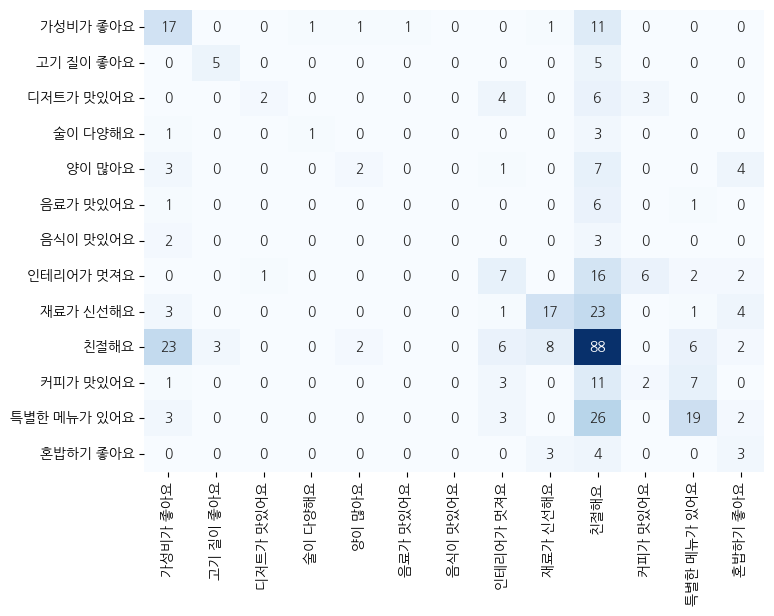

In [11]:
### 전체 데이터로 학습
X = tfidf_okt_matrix
y = train['keyword2']

svm = SVC(C=10, kernel='rbf', gamma=0.1, random_state=2024, probability=True)
svm.fit(X, y)
svm_pred = svm.predict(X)
svm_proba = svm.predict_proba(X)

train_loss = loss_fn(torch.tensor(svm_proba), torch.tensor(y.values, dtype=torch.long)).item()
train_acc = accuracy_score(y, svm_pred)
train_f1 = f1_score(y, svm_pred, average='weighted')
print(f'[SVC] Train Loss = {round(train_loss,4)}')
print(f'[SVC] Train Accuracy = {round(train_acc,4)}')
print(f'[SVC] Train F1 Score = {round(train_f1,4)}')

svm_test_pred = svm.predict(X_test)
svm_test_proba = svm.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(svm_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, svm_test_pred)
test_f1 = f1_score(y_test, svm_test_pred, average='weighted')
print(f'[SVC] Test Loss = {round(test_loss,4)}')
print(f'[SVC] Test Accuracy = {round(test_acc,4)}')
print(f'[SVC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

model_results = []
model_results.append(['SVC', valid_loss, valid_acc, valid_f1, test_loss, test_acc, test_f1])

In [12]:
import pickle
with open('svm.pkl', 'wb') as file:
    pickle.dump(svm, file)

### XGB

[XGBC] Validation Loss = 1.9071
[XGBC] Validation Accuracy = 0.8325
[XGBC] Validation F1 Score = 0.8248
[XGBC] Test Loss = 2.3442
[XGBC] Test Accuracy = 0.3675
[XGBC] Test F1 Score = 0.3637


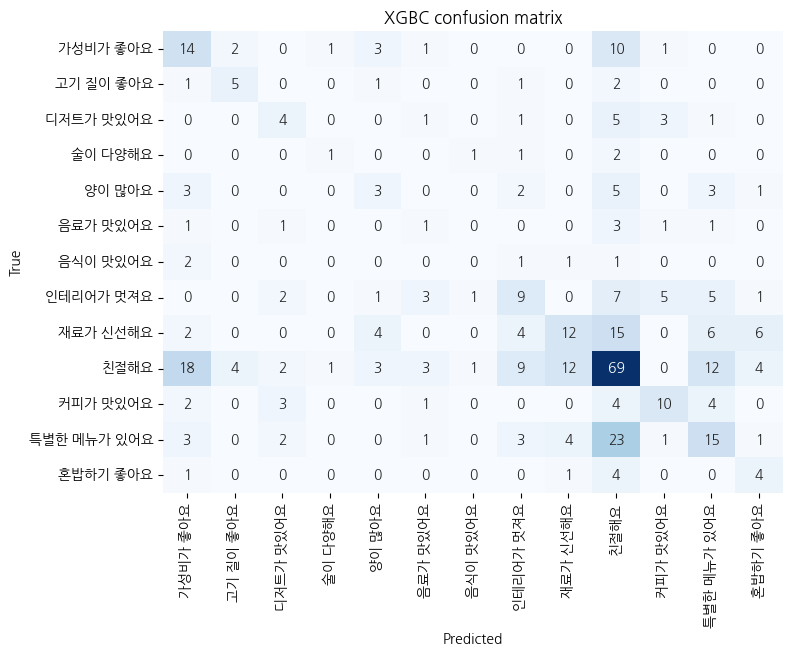

In [16]:
### XGB
xgbc = XGBClassifier(n_estimators=500, learning_rate=0.3, max_depth=9,
                     min_child_weight=1, subsample=0.5, random_state=2024)
xgbc.fit(X_train, y_train)
xgbc_pred = xgbc.predict(X_valid)
xgbc_proba = xgbc.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(xgbc_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, xgbc_pred)
valid_f1 = f1_score(y_valid, xgbc_pred, average='weighted')
print(f'[XGBC] Validation Loss = {round(valid_loss,4)}')
print(f'[XGBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[XGBC] Validation F1 Score = {round(valid_f1,4)}')

xgbc_test_pred = xgbc.predict(X_test)
xgbc_test_proba = xgbc.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(xgbc_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, xgbc_test_pred)
test_f1 = f1_score(y_test, xgbc_test_pred, average='weighted')
print(f'[XGBC] Test Loss = {round(test_loss,4)}')
print(f'[XGBC] Test Accuracy = {round(test_acc,4)}')
print(f'[XGBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, xgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.title('XGBC confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[XGB] Train Loss = 1.6944
[XGB] Train Accuracy = 1.0
[XGB] Train F1 Score = 1.0
[XGB] Test Loss = 2.3581
[XGB] Test Accuracy = 0.325
[XGB] Test F1 Score = 0.3189


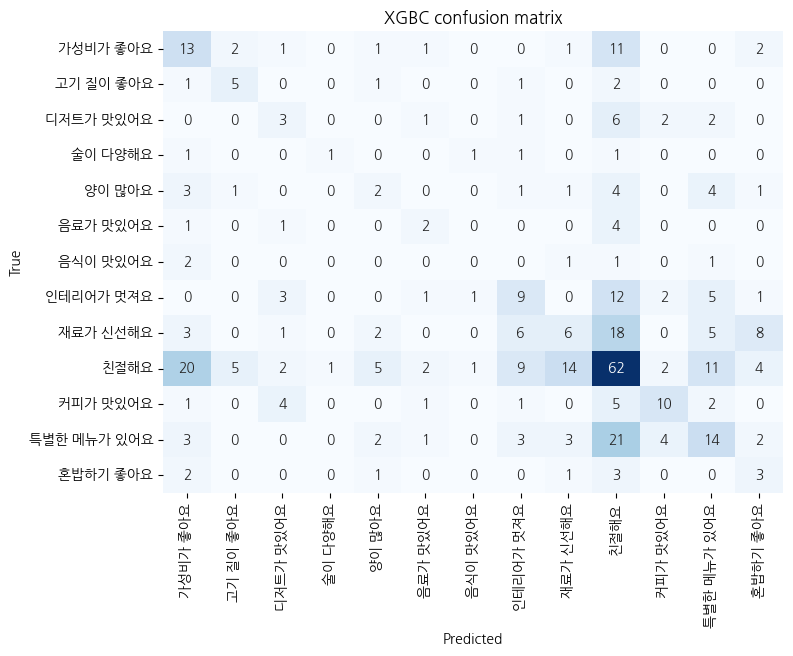

In [17]:
### 전체 데이터로 학습
X = tfidf_okt_matrix
y = train['keyword2']

xgbc = XGBClassifier(n_estimators=500, learning_rate=0.3, max_depth=9,
                     min_child_weight=1, subsample=0.5, random_state=2024)
xgbc.fit(X, y)
xgbc_pred = xgbc.predict(X)
xgbc_proba = xgbc.predict_proba(X)

train_loss = loss_fn(torch.tensor(xgbc_proba), torch.tensor(y.values, dtype=torch.long)).item()
train_acc = accuracy_score(y, xgbc_pred)
train_f1 = f1_score(y, xgbc_pred, average='weighted')
print(f'[XGB] Train Loss = {round(train_loss,4)}')
print(f'[XGB] Train Accuracy = {round(train_acc,4)}')
print(f'[XGB] Train F1 Score = {round(train_f1,4)}')

xgbc_test_pred = xgbc.predict(X_test)
xgbc_test_proba = xgbc.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(xgbc_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, xgbc_test_pred)
test_f1 = f1_score(y_test, xgbc_test_pred, average='weighted')
print(f'[XGB] Test Loss = {round(test_loss,4)}')
print(f'[XGB] Test Accuracy = {round(test_acc,4)}')
print(f'[XGB] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, xgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.title('XGBC confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

model_results.append(['XGBC', valid_loss, valid_acc, valid_f1, test_loss, test_acc, test_f1])

In [18]:
import pickle
with open('xgbc.pkl', 'wb') as file:
    pickle.dump(xgbc, file)

### LGBM

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

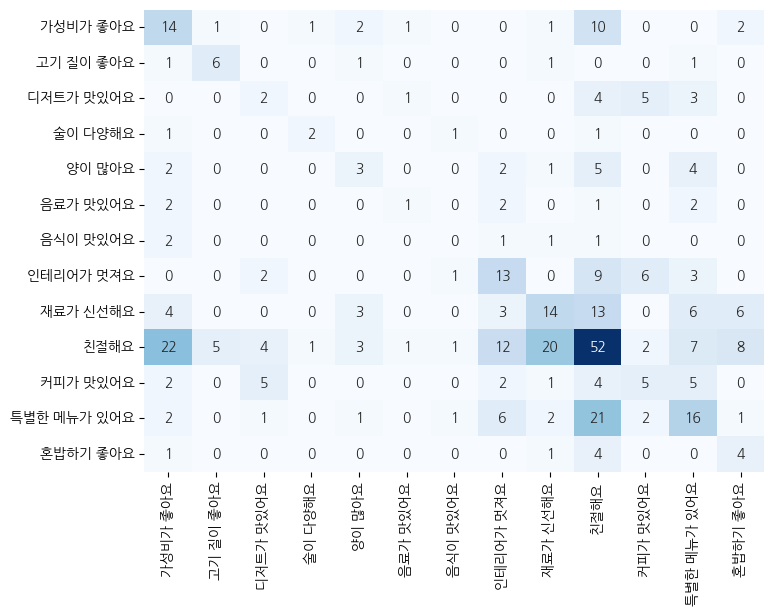

In [19]:
### lgbm
lgbc = LGBMClassifier(n_estimators=1000, max_depth=10, learning_rate=0.2,
                      random_state=2024)
lgbc.fit(X_train, y_train)
lgbc_pred = lgbc.predict(X_valid)
lgbc_proba = lgbc.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(lgbc_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, lgbc_pred)
valid_f1 = f1_score(y_valid, lgbc_pred, average='weighted')
print(f'[LGBC] Validation Loss = {round(valid_loss,4)}')
print(f'[LGBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[LGBC] Validation F1 Score = {round(valid_f1,4)}')

lgbc_test_pred = lgbc.predict(X_test)
lgbc_test_proba = lgbc.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(lgbc_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, lgbc_test_pred)
test_f1 = f1_score(y_test, lgbc_test_pred, average='weighted')
print(f'[LGBC] Test Loss = {round(test_loss,4)}')
print(f'[LGBC] Test Accuracy = {round(test_acc,4)}')
print(f'[LGBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, lgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

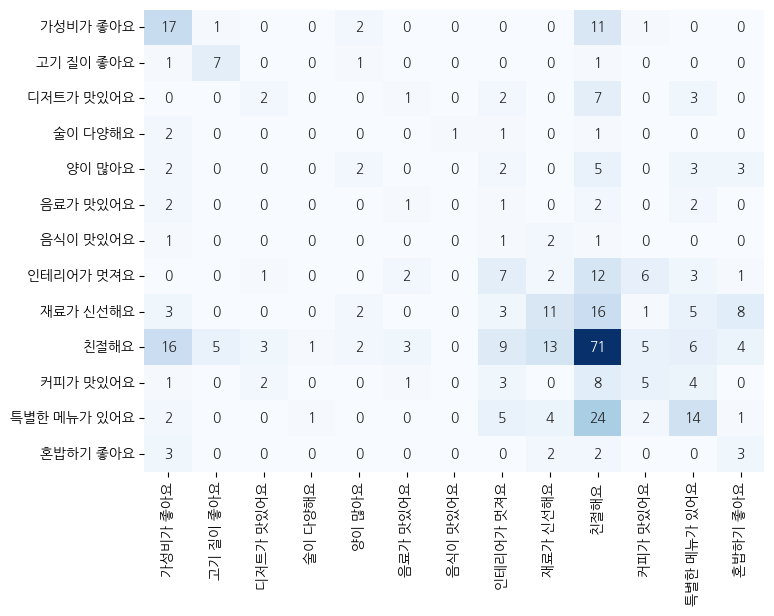

In [20]:
### 전체 데이터로 학습
X = tfidf_okt_matrix
y = train['keyword2']

lgbc = LGBMClassifier(n_estimators=1000, max_depth=10, learning_rate=0.2,
                      random_state=2024)
lgbc.fit(X, y)
lgbc_pred = lgbc.predict(X)
lgbc_proba = lgbc.predict_proba(X)

train_loss = loss_fn(torch.tensor(lgbc_proba), torch.tensor(y.values, dtype=torch.long)).item()
train_acc = accuracy_score(y, lgbc_pred)
train_f1 = f1_score(y, lgbc_pred, average='weighted')
print(f'[LGBM] Train Loss = {round(train_loss,4)}')
print(f'[LGBM] Train Accuracy = {round(train_acc,4)}')
print(f'[LGBM] Train F1 Score = {round(train_f1,4)}')

lgbc_test_pred = lgbc.predict(X_test)
lgbc_test_proba = lgbc.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(lgbc_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, lgbc_test_pred)
test_f1 = f1_score(y_test, lgbc_test_pred, average='weighted')
print(f'[LGBM] Test Loss = {round(test_loss,4)}')
print(f'[LGBM] Test Accuracy = {round(test_acc,4)}')
print(f'[LGBM] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, lgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

model_results.append(['LGBM', valid_loss, valid_acc, valid_f1, test_loss, test_acc, test_f1])

In [22]:
import pickle
with open('lgbc.pkl', 'wb') as file:
    pickle.dump(lgbc, file)

### RandomForest

[RF] Validation Loss = 2.0651
[RF] Validation Accuracy = 0.8276
[RF] Validation F1 Score = 0.8071
[RF] Test Loss = 2.4414
[RF] Test Accuracy = 0.2625
[RF] Test F1 Score = 0.2608


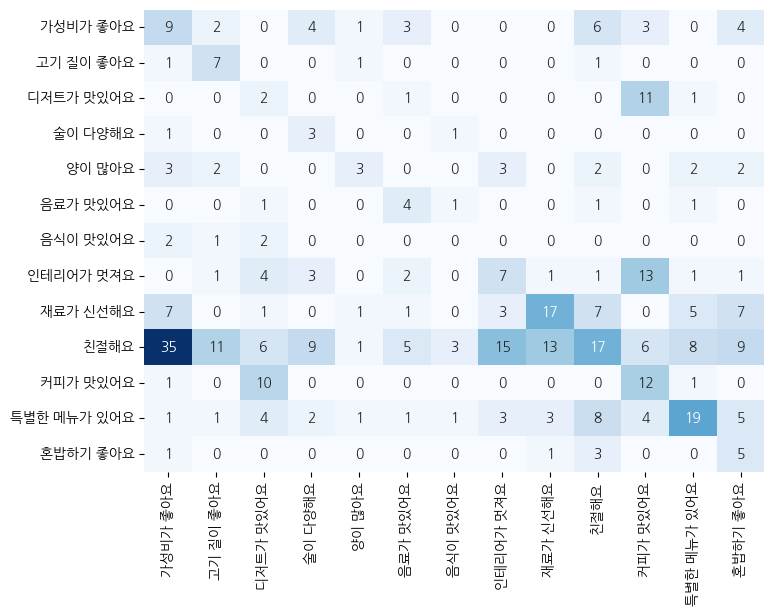

In [23]:
rf = RandomForestClassifier(n_estimators=300, max_features=0.7, random_state=2024)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_proba = rf.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(rf_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, rf_pred)
valid_f1 = f1_score(y_valid, rf_pred, average='weighted')
print(f'[RF] Validation Loss = {round(valid_loss,4)}')
print(f'[RF] Validation Accuracy = {round(valid_acc,4)}')
print(f'[RF] Validation F1 Score = {round(valid_f1,4)}')

rf_test_pred = rf.predict(X_test)
rf_test_proba = rf.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(rf_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, rf_test_pred)
test_f1 = f1_score(y_test, rf_test_pred, average='weighted')
print(f'[RF] Test Loss = {round(test_loss,4)}')
print(f'[RF] Test Accuracy = {round(test_acc,4)}')
print(f'[RF] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

[RF] Train Loss = 1.8142
[RF] Train Accuracy = 1.0
[RF] Train F1 Score = 1.0
[RF] Test Loss = 2.4357
[RF] Test Accuracy = 0.295
[RF] Test F1 Score = 0.3011


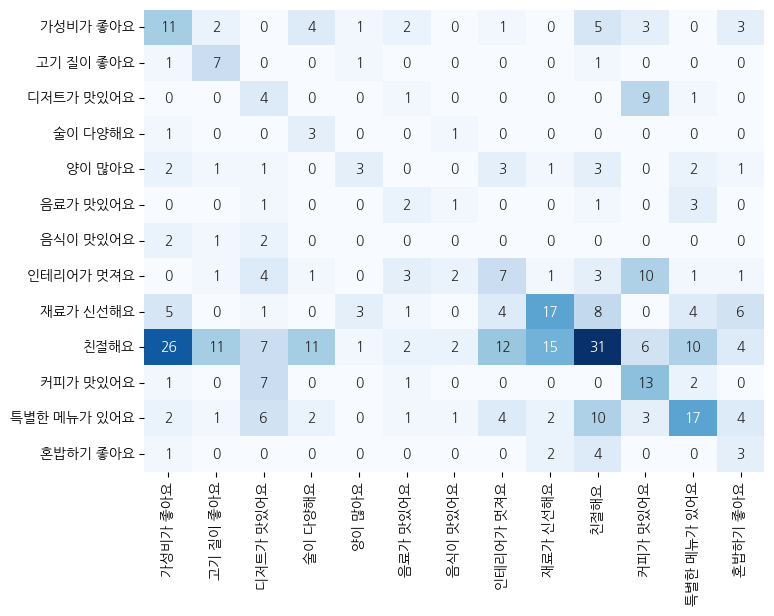

In [24]:
### 전체 데이터로 학습
X = tfidf_okt_matrix
y = train['keyword2']

rf = RandomForestClassifier(n_estimators=300, max_features=0.7, random_state=2024)
rf.fit(X, y)
rf_pred = rf.predict(X)
rf_proba = rf.predict_proba(X)

train_loss = loss_fn(torch.tensor(rf_proba), torch.tensor(y.values, dtype=torch.long)).item()
train_acc = accuracy_score(y, rf_pred)
train_f1 = f1_score(y, rf_pred, average='weighted')
print(f'[RF] Train Loss = {round(train_loss,4)}')
print(f'[RF] Train Accuracy = {round(train_acc,4)}')
print(f'[RF] Train F1 Score = {round(train_f1,4)}')

rf_test_pred = rf.predict(X_test)
rf_test_proba = rf.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(rf_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, rf_test_pred)
test_f1 = f1_score(y_test, rf_test_pred, average='weighted')
print(f'[RF] Test Loss = {round(test_loss,4)}')
print(f'[RF] Test Accuracy = {round(test_acc,4)}')
print(f'[RF] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

model_results.append(['RF', valid_loss, valid_acc, valid_f1, test_loss, test_acc, test_f1])

In [25]:
import pickle
with open('rf.pkl', 'wb') as file:
    pickle.dump(rf, file)

### DT

[DT] Validation Loss = 2.0265
[DT] Validation Accuracy = 0.6626
[DT] Validation F1 Score = 0.6564
[DT] Test Loss = 2.4866
[DT] Test Accuracy = 0.2025
[DT] Test F1 Score = 0.21


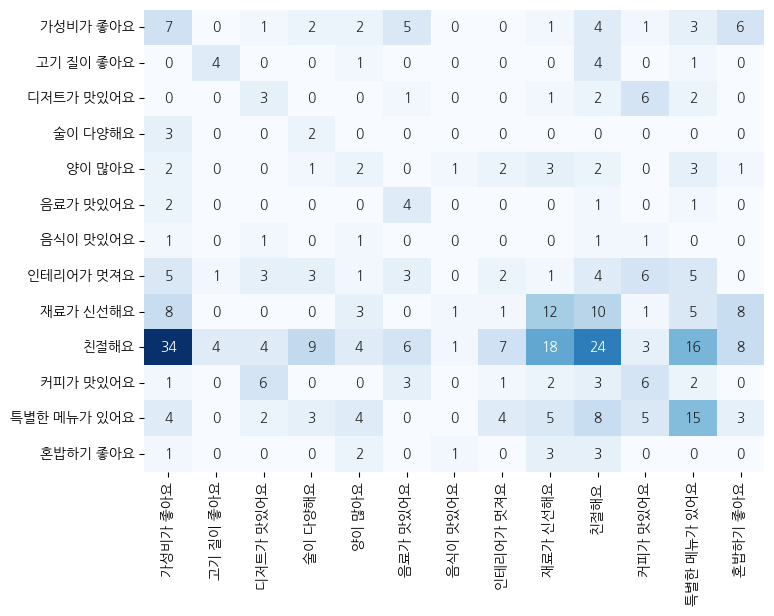

In [26]:
dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=None, random_state=2024)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
dt_proba = dt.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(dt_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, dt_pred)
valid_f1 = f1_score(y_valid, dt_pred, average='weighted')
print(f'[DT] Validation Loss = {round(valid_loss,4)}')
print(f'[DT] Validation Accuracy = {round(valid_acc,4)}')
print(f'[DT] Validation F1 Score = {round(valid_f1,4)}')

dt_test_pred = dt.predict(X_test)
dt_test_proba = dt.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(dt_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, dt_test_pred)
test_f1 = f1_score(y_test, dt_test_pred, average='weighted')
print(f'[DT] Test Loss = {round(test_loss,4)}')
print(f'[DT] Test Accuracy = {round(test_acc,4)}')
print(f'[DT] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, dt_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

[DT] Train Loss = 1.6891
[DT] Train Accuracy = 1.0
[DT] Train F1 Score = 1.0
[DT] Test Loss = 2.4741
[DT] Test Accuracy = 0.215
[DT] Test F1 Score = 0.2239


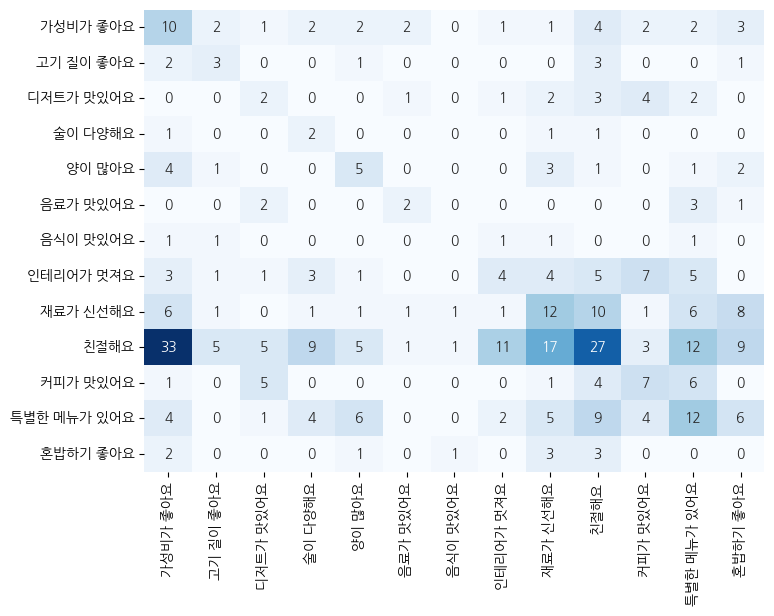

In [27]:
X = tfidf_okt_matrix
y = train['keyword2']

dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=None, random_state=2024)
dt.fit(X, y)
dt_pred = dt.predict(X)
dt_proba = dt.predict_proba(X)

train_loss = loss_fn(torch.tensor(dt_proba), torch.tensor(y.values, dtype=torch.long)).item()
train_acc = accuracy_score(y, dt_pred)
train_f1 = f1_score(y, dt_pred, average='weighted')
print(f'[DT] Train Loss = {round(train_loss,4)}')
print(f'[DT] Train Accuracy = {round(train_acc,4)}')
print(f'[DT] Train F1 Score = {round(train_f1,4)}')

dt_test_pred = dt.predict(X_test)
dt_test_proba = dt.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(dt_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, dt_test_pred)
test_f1 = f1_score(y_test, dt_test_pred, average='weighted')
print(f'[DT] Test Loss = {round(test_loss,4)}')
print(f'[DT] Test Accuracy = {round(test_acc,4)}')
print(f'[DT] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, dt_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

model_results.append(['DT', valid_loss, valid_acc, valid_f1, test_loss, test_acc, test_f1])

In [28]:
import pickle
with open('dt.pkl', 'wb') as file:
    pickle.dump(dt, file)

### Voting

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

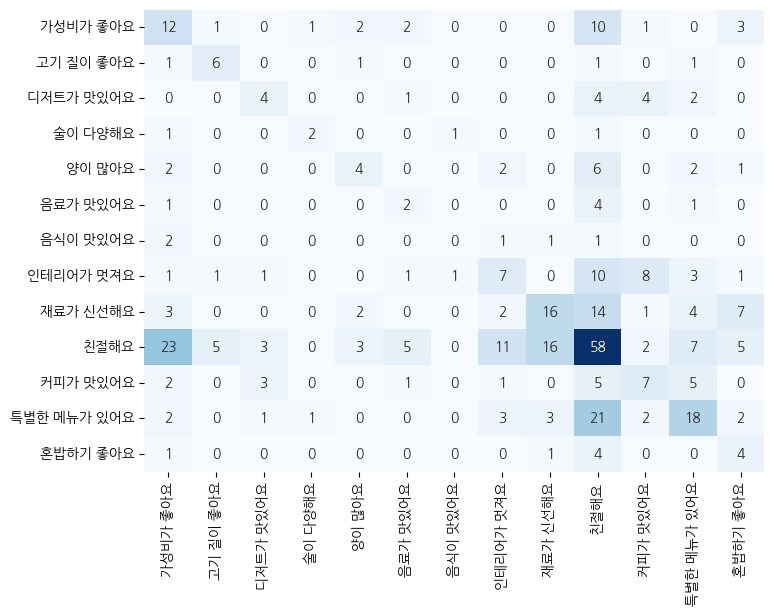

In [ ]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[
    ('dt',dt),
    ('rf',rf),
    ('svm', svm),
    ('xgbc', xgbc),
    ('lgbc', lgbc)
], voting='soft')

voting.fit(X_train, y_train)
voting_pred = voting.predict(X_valid)
voting_proba = voting.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(voting_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, voting_pred)
valid_f1 = f1_score(y_valid, voting_pred, average='weighted')
print(f'[Voting] Validation Accuracy = {round(valid_acc,4)}')
print(f'[Voting] Validation F1 Score = {round(valid_f1,4)}')

voting_test_pred = voting.predict(X_test)
voting_test_proba = voting.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(voting_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, voting_test_pred)
test_f1 = f1_score(y_test, voting_test_pred, average='weighted')
print(f'[Voting] Test Accuracy = {round(test_acc,4)}')
print(f'[Voting] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, voting_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

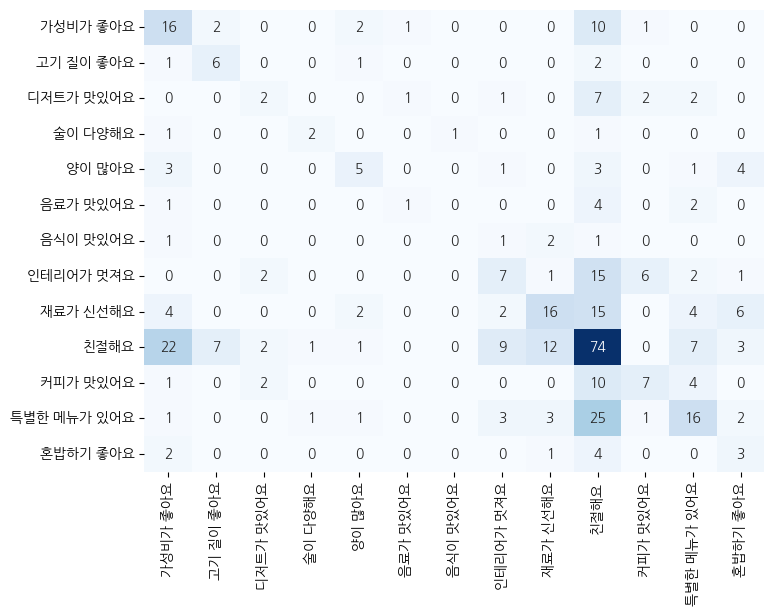

In [ ]:
### 전체 데이터로 학습
X = tfidf_okt_matrix
y = train['keyword2']

voting = VotingClassifier(estimators=[
    ('dt',dt),
    ('rf',rf),
    ('svm', svm),
    ('xgbc', xgbc),
    ('lgbc', lgbc)
], voting='soft')

voting.fit(X, y)
voting_pred = voting.predict(X)
voting_proba = voting.predict_proba(X)

train_loss = loss_fn(torch.tensor(voting_proba), torch.tensor(y.values, dtype=torch.long)).item()
train_acc = accuracy_score(y, voting_pred)
train_f1 = f1_score(y, voting_pred, average='weighted')
print(f'[Voting] Train Loss = {round(train_loss,4)}')
print(f'[Voting] Train Accuracy = {round(train_acc,4)}')
print(f'[Voting] Train F1 Score = {round(train_f1,4)}')

voting_test_pred = voting.predict(X_test)
voting_test_proba = voting.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(voting_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, voting_test_pred)
test_f1 = f1_score(y_test, voting_test_pred, average='weighted')
print(f'[Voting] Test Accuracy = {round(test_acc,4)}')
print(f'[Voting] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, voting_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

model_results.append(['Voting', valid_loss, valid_acc, valid_f1, test_loss, test_acc, test_f1])

### 결과 시각화

In [ ]:
model_results = pd.DataFrame(model_results)
model_results.columns = ['model', 'valid_loss', 'valid_acc', 'valid_f1', 'test_loss', 'test_acc', 'test_f1']
model_results

,model,valid_loss,valid_acc,valid_f1,test_loss,test_acc,test_f1
0,SVC,1.810624,0.938424,0.936215,2.313506,0.4075,0.382687
1,XGBC,1.907131,0.832512,0.824823,2.358105,0.3250,0.318921
2,LGBM,1.833094,0.866995,0.857997,2.334078,0.3500,0.336293
3,RF,2.065085,0.827586,0.807097,2.435735,0.2950,0.301102
4,DT,2.026529,0.662562,0.656421,2.474090,0.2150,0.223909
5,Voting,1.921995,0.901478,0.894554,2.369644,0.3875,0.377167


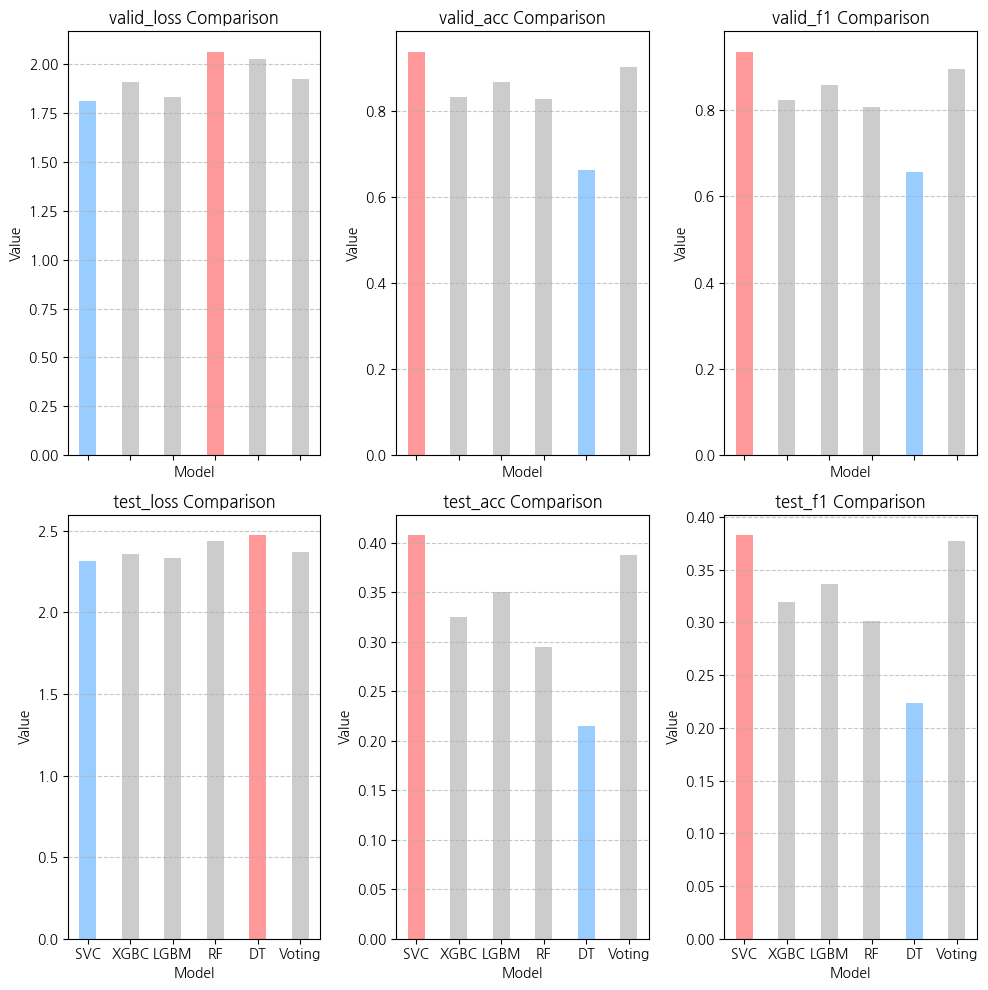

In [ ]:
df_long = pd.melt(model_results, id_vars='model', var_name='metric', value_name='value')

metrics = ['valid_loss', 'valid_acc', 'valid_f1', 'test_loss', 'test_acc', 'test_f1']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    data = df_long[df_long['metric'] == metric]
    bar_width = 0.4

    max_value = data['value'].max()
    min_value = data['value'].min()
    colors = data['value'].apply(lambda x: '#FF9999' if x == max_value else ('#99CCFF' if x == min_value else '#CCCCCC'))

    bars = ax.bar(data['model'], data['value'], color=colors, width=bar_width)

    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')

    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### predict_review

In [32]:
def predict_review(model, review, tfidf_vectorizer, label_encoder):
    # 입력된 리뷰를 TF-IDF로 변환
    review_tfidf = tfidf_vectorizer.transform([review])

    # 모델에 입력하고 예측 수행
    output = model.predict(review_tfidf)

    # 인코딩된 라벨을 원래의 라벨로 디코딩
    decoded_label = label_encoder.inverse_transform(output)[0]

    return decoded_label

In [33]:
### svm
filename = './svm.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review(model, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 친절해요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 특별한 메뉴가 있어요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 친절해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 친절해요


In [34]:
### xgbc
filename = './xgbc.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review(model, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [35]:
### lgbm
filename = './lgbc.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review(model, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [31]:
### rf
filename = './rf.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review(model, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 가성비가 좋아요


In [36]:
### dt
filename = './dt.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

for _ in range(5):
  review_input = input("리뷰를 입력하세요: ")

  predicted_label = predict_review(model, review_input, tfidf_okt, le)
  print(f"예측된 키워드: {predicted_label}")

리뷰를 입력하세요: 이 집 밥이 참 맛있어요
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 물 쏟았는데 직원분이 냅킨을 갖다주셨어요 ㅠㅠ 너무 친절해요
예측된 키워드: 재료가 신선해요
리뷰를 입력하세요: 한 끼 만원인 시대에 한정식이 7000원이라니... 가성비가 최고입니다
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 특이한 빵이 많아요!
예측된 키워드: 가성비가 좋아요
리뷰를 입력하세요: 인테리어가 쾌적하고 넓어요. 아이들이 좋아하네요.
예측된 키워드: 술이 다양해요
